# MNIST - playing around

data source: http://yann.lecun.com/exdb/mnist/ 

## Models 
First with torch

Later from scratch

## Model with Torch

In [1]:
# initialize libs
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from tqdm.auto import trange
np.set_printoptions(suppress=True)

# torch libs
import torch
import torch.nn as nn 
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

# load data libs
import requests
import gzip
import os
import hashlib


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/Users/erirosv/.pyenv/versions/3.10.11/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# getting the data to train the model

def get_data(url):
    file_path = os.path.join('/tmp', hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(file_path):
        with open (file_path, 'rb') as f:
            data = f.read()
    else:
        with open(file_path, 'wb') as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

In [3]:
x_train = get_data("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = get_data("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = get_data("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

### Model

In [4]:
class ApexNet(torch.nn.Module):
    def __init__(self) -> None:
        """
        Initialize class with an constructor and parameters
        """
        super(ApexNet, self).__init__()
        self.linear_1 = nn.Linear(784, 128, bias=False)
        self.linear_2 = nn.Linear(128, 10, bias=False)
        self.soft_max = nn.LogSoftmax(dim=1)

    def forward(self, x):
        """
        Forward pass for the model
        """
        x = F.relu(self.linear_1(x))
        x = self.linear_2(x)
        s = self.soft_max(x)
        return x

### Training

loss 0.188 accuracy 0.922: 100%|██████████| 1000/1000 [00:00<00:00, 1001.95it/s]


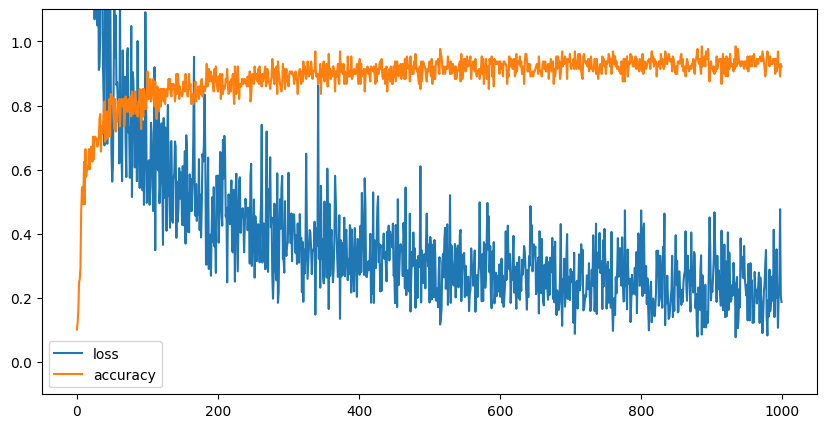

In [5]:
# Define the model, loss function, and optimizer
model = ApexNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)

# Set the batch size and create empty lists to store loss and accuracy values
batch_size = 128
losses = []
accuracies = []

# Train the model
from tqdm.auto import trange
t = trange(1000)
for i in t:
    sample = np.random.randint(0, x_train.shape[0], size=(batch_size))
    X = torch.tensor(x_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[sample]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    accuracies.append(accuracy.item())
    t.set_description("loss %.3f accuracy %.3f" % (loss, accuracy))
    
# Plot the loss and accuracy over time
figsize(10,5)
plt.ylim(-0.1, 1.1)
plot(losses, label='loss')
plot(accuracies, label='accuracy')
plt.legend()
plt.show()


### Evaluation

In [6]:
Y_test_predictions = torch.argmax(model(torch.tensor(x_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(y_test == Y_test_predictions).mean()

0.9272

### Breakdown of gradients 

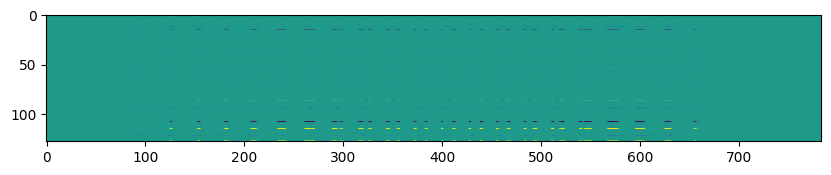

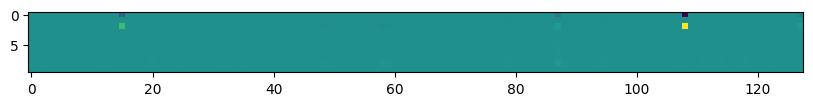

In [7]:
samp = [1,2,3,]
model.zero_grad()
out = model(torch.tensor(x_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()

loss = loss_function(out, torch.tensor(y_test[samp]).long()).mean()
loss.backward()

imshow(model.linear_1.weight.grad)
figure()
imshow(model.linear_2.weight.grad)

## Model from scratch here

In [8]:
# making the sam layer from torch with numpy
layer_1 = np.zeros((784, 128), dtype=np.float32)
layer_2 = np.zeros((128, 10), dtype=np.float32)

# checking the types
(layer_1.dtype, layer_2.dtype)

(dtype('float32'), dtype('float32'))

In [9]:
# checking memory address for layer_1 and layer_2
(id(layer_1), id(layer_2))

(5028741008, 5028451632)

In [10]:
# used stupid name for layer in torch model
# copy weight from torch model
layer_1[:] = model.linear_1.weight.detach().numpy().T
layer_2[:] = model.linear_2.weight.detach().numpy().T

In [11]:
# forward-pass in numpy
def forward(x):
    x = x.dot(layer_1)
    x = np.maximum(x, 0)
    x = x.dot(layer_2)
    return x

In [12]:
Y_test_predictions_out = forward(x_test.reshape((-1, 28*28)))
Y_test_predictions = np.argmax(Y_test_predictions_out, axis=1)
(y_test == Y_test_predictions).mean()

0.9272

### Training (numpy)

In [13]:
ret = (-Y_test_predictions_out[range(Y_test_predictions_out.shape[0]), y_test] 
       + np.log(np.exp(Y_test_predictions_out).sum(axis=1)))


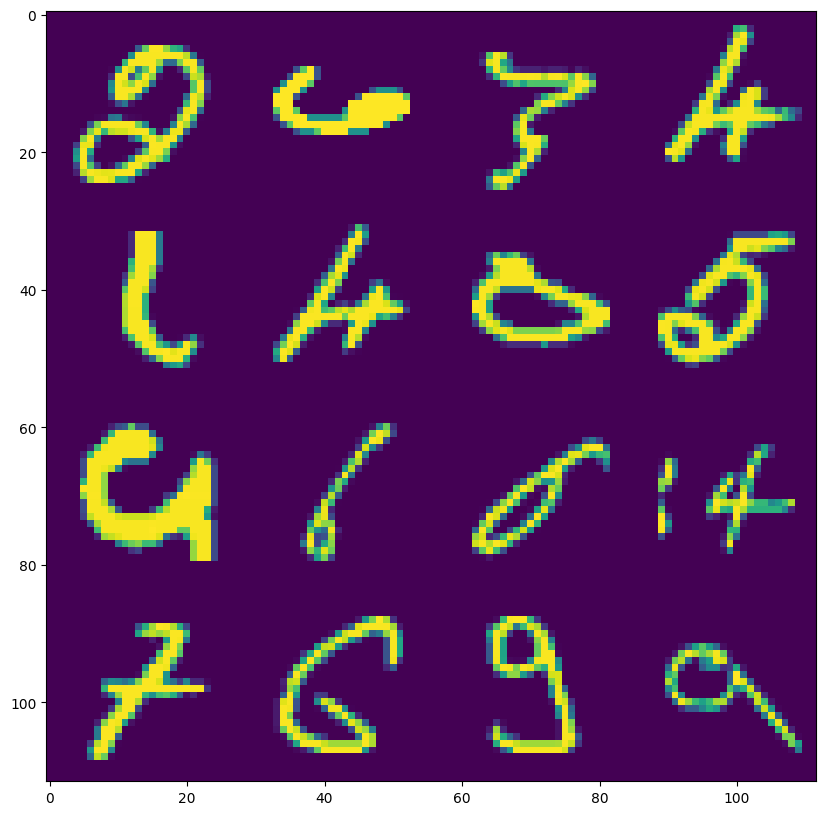

In [14]:
# grid
grid_var = 4
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=True)[0:grid_var*grid_var]
temp = x_test[[x[1] for x in grid]]

figsize(10,10)
imshow(np.concatenate(temp.reshape((grid_var, 28*grid_var, 28)), axis=1))

In [15]:
sample = 1
-Y_test_predictions_out[sample, y_test[0]] + np.log(np.exp(Y_test_predictions_out[sample]).sum())

35.677643

In [16]:
-np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])]) + np.log(np.exp(Y_test_predictions_out).sum(axis=1))

array([0.00000381, 0.00014687, 0.00015354, ..., 0.03086472, 0.17852592,
       0.00007057], dtype=float32)

In [17]:
Y_test_predictions_out[:, y_test].shape

(10000, 10000)

In [18]:
Y_test_predictions_out[y_test.reshape((1,-1))].shape

(1, 10000, 10)

In [19]:
np.array([Y_test_predictions_out[i, y_test[i]] for i in range(Y_test_predictions_out.shape[0])])

array([19.607405, 22.597658, 11.661818, ..., 15.903465, 14.714717,
       17.251732], dtype=float32)

In [20]:
def forward_backwards(x, y):
    # define training 
    ret = np.zeros((len(y), 10), np.float32)
    ret[range(ret.shape[0]), y] = 1
    
    # --- forward
    x_layer_1 = x.dot(layer_1)
    relu = np.maximum(x_layer_1, 0)
    x_layer_2 = relu.dot(layer_2) # baked in x_relu = np.maximum(x_layer_1, 0)
    x_log_sum = x_layer_2 - log_sum_exp(x_layer_2).reshape((-1, 1))
    loss = (-ret * x_log_sum).mean(axis=1)
    
    # --- derivative: log_soft_max
    rret = -ret / len(y)
    d_log_sum = rret - np.exp(x_log_sum) * rret.sum(axis=1).reshape((-1,1)) # derivative layer 2
    d_relu =d_log_sum.dot(layer_2.T) 
    d_layer_2 = d_relu.T.dot(d_log_sum) # d_relu = d_log_sum.dot(layer_2.T)
    
    dd_layer_1 = (relu > 0).astype(np.float32) * (d_log_sum.dot(layer_2.T)) # derivative relu
    d_layer_1 = x.T.dot(dd_layer_1) # derivative layer 1

    return loss, x_layer_2, d_layer_1, d_layer_2

def log_sum_exp(x):
    return x.max(axis=1) + np.log(np.exp((x-x.max(axis=1).reshape((-1,1))).sum(axis=1)))

/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:25: RuntimeWarning: divide by zero encountered in log
  return x.max(axis=1) + np.log(np.exp((x-x.max(axis=1).reshape((-1,1))).sum(axis=1)))
/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:11: RuntimeWarning: invalid value encountered in multiply
  loss = (-ret * x_log_sum).mean(axis=1)


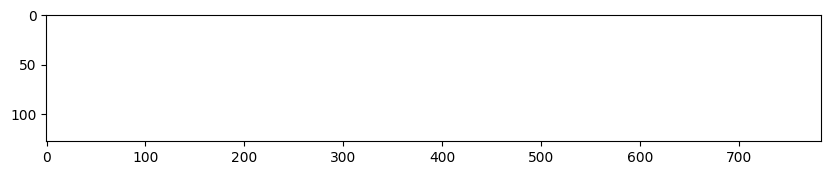

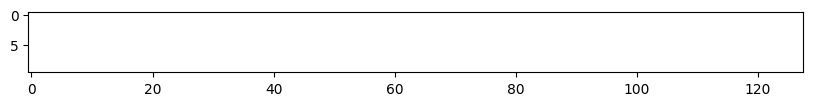

In [29]:
sample = [0,1,2,3]
loss, x_layer_2, d_layer_1, d_layer_2 = forward_backwards(x_test[sample].reshape((-1, 28*28)), y_test[sample])
imshow(d_layer_1.T)
figure()
imshow(d_layer_2.T)

(1, 784) (1, 128) (1, 128) (1, 10)
(128, 10) (1, 128)


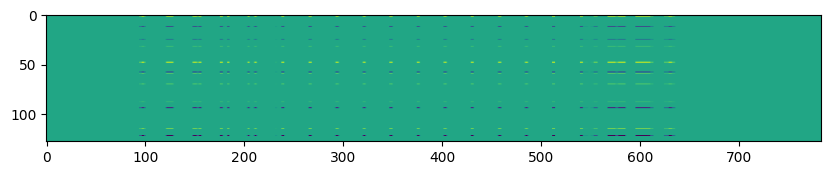

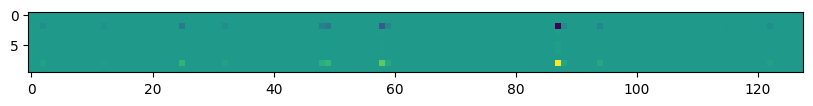

In [22]:
# forward pass
x = x_test[1:2].reshape((-1, 28*28))
x_layer_1 = x.dot(layer_1)
x_relu = np.maximum(x_layer_1, 0)
x_layer_2 = x_relu.dot(layer_2)

# check the shapes of the layers
print(x.shape, x_layer_1.shape, x_relu.shape, x_layer_2.shape)

# backward pass (testing)
out = np.zeros((1,10), np.float32)
out[0,2] = 1

# derivated: log_softmax
out = torch.tensor(out)
gradient_in = torch.tensor(x_layer_2, requires_grad=True)
gradient_out = torch.nn.functional.log_softmax(gradient_in, dim=1)
loss = (-out * gradient_out).mean()
loss.backward()
dx_sm = gradient_in.grad.numpy()

# derivated (d): linera_2
d_layer2 = x_relu.T.dot(dx_sm)
dx_relu = dx_sm.dot(layer_2.T)

# derivate: ReLu (chainrule)
dx_layer1 = (x_relu > 0).astype(np.float32) * dx_relu

#derivate: layer 1
d_layer1 = x.T.dot(dx_layer1)

print(d_layer2.shape, dx_relu.shape)
imshow(d_layer1.T)
figure()
imshow(d_layer2.T)


In [23]:
(dx_relu > 0).astype(np.float32)

array([[1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
        1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
        0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0.]],
      dtype=float32)

In [24]:
def initialize_layer(m, h):
    return (np.random.uniform(-1, 1, size=(m,h)) / np.sqrt(m * h)).astype(np.float32)

In [25]:
# vaiables
learning_rate = 0.001
batch_size = 128
accuracies, losses = [], []
IMG_SIZE = 28*28

# init the new layers
np.random.seed(1000)
l1 = initialize_layer(IMG_SIZE, 128)
l2 = initialize_layer(128, 10)


In [27]:
for i in (t := trange(1000)):
    sample = np.random.randint(0, x_train.shape[0], size=batch_size)
    X = x_train[sample].reshape((-1, IMG_SIZE))
    Y = y_train[sample]
    loss, x_layer_2, d_layer1, d_layer2 = forward_backwards(X, Y)
    cc = np.argmax(x_layer_1, axis=1)
    accuracy = (cc == Y).mean()

    # SGD
    layer_1 = layer_1 - learning_rate * d_layer1
    layer_2 = layer_2 - learning_rate * d_layer2

    

  0%|          | 0/1000 [00:00<?, ?it/s]/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:25: RuntimeWarning: divide by zero encountered in log
  return x.max(axis=1) + np.log(np.exp((x-x.max(axis=1).reshape((-1,1))).sum(axis=1)))
/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:11: RuntimeWarning: invalid value encountered in multiply
  loss = (-ret * x_log_sum).mean(axis=1)
/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:15: RuntimeWarning: overflow encountered in exp
  d_log_sum = rret - np.exp(x_log_sum) * rret.sum(axis=1).reshape((-1,1)) # derivative layer 2
/var/folders/wq/7cvbc6jd411dg1wd3j_ksjv80000gn/T/ipykernel_13019/3384627525.py:19: RuntimeWarning: invalid value encountered in multiply
  dd_layer_1 = (relu > 0).astype(np.float32) * (d_log_sum.dot(layer_2.T)) # derivative relu
100%|██████████| 1000/1000 [00:01<00:00, 939.77it/s]
